In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def Magdelaine1(pat):
    print(f'Running patient {pat}...')

    # Model parameters
    if pat == 2:
        M = 72  # patient mass (kg)
        ksi = 197  # Insulin sensitivity (mg glucose/U/min)
        kl = 1.94  # Liver endogenous glucose consumption (mg glucose/dL/min)
        Tu = 122  # min
        ku_Vi = 59e-3  # min/dl
        Tr = 183  # min
        kr_Vb = 2.4e-3  # min/dl
        tend = 48 * 60
    elif pat == 3:
        M = 94  # patient mass (kg)
        ksi = 274  # Insulin sensitivity (mg glucose/U/min)
        kl = 1.72  # Liver endogenous glucose consumption (mg glucose/dL/min)
        Tu = 88  # min
        ku_Vi = 62e-3  # min/dl
        Tr = 49  # min
        kr_Vb = 2e-3  # min/dl
        tend = 48 * 60 #changed pat 3 to 48 hours for consitency, used previous values
    else:
        raise ValueError('We do not know that patient.')

    Vb = 0.65 * M  # dL blood
    Vi = 2.5 * M  # dL for insulin
    kb = 128 / M  # Brain endogenous glucose consumption (mg glucose/dL/min)

    # Timings (all in min)
    dt = 0.1
    t = np.arange(dt, tend + dt, dt) # An array that goes from 0.1 to tend + 0.1, with an interval of 0.1
    int_t = t.astype(int)
    gathert = int(1 / dt)
    tsave = np.arange(dt, tend + dt, 1) 
    int_tsave = tsave.astype(int)

    A = np.array([[0, -ksi, 0, 1, 0],
                  [0, 0, 1, 0, 0],
                  [0, -1 / Tu**2, -2 / Tu, 0, 0],
                  [0, 0, 0, 0, 1],
                  [0, 0, 0, -1 / Tr**2, -2 / Tr]])
    B = np.array([[0, 0],
                  [0, 0],
                  [ku_Vi / Tu**2, 0],
                  [0, 0],
                  [0, kr_Vb / Tr**2]])
    E = np.array([kl - kb, 0, 0, 0, 0])

    Ieq = (kl - kb) / ksi
    if pat == 2:
        X0 = np.array([220, Ieq, 0, 0, 0])  # IF2
    elif pat == 3:
        X0 = np.array([125, Ieq, 0, 0, 0])  # IF3

    X = X0

    # Input carbohydrates (mg)
    rt = np.zeros_like(int_t)

    if pat == 2:
        rt[int_t == 24 * 60] = 128
        rt[int_t == 25.5 * 60] = 15
        rt[int_t == 37 * 60] = 150
        rt[int_t == 41 * 60] = 100
        rt[int_t == 42.5 * 60] = 7.5
        rt[int_t == 44.5 * 60] = 15
        rt[int_t == 48 * 60] = 125
    elif pat == 3:
        rt[int_t == 6 * 60] = 15
        rt[int_t == 3 * 60] = 15
        rt[int_t == 7 * 60] = 20
        rt[int_t == 12.5 * 60] = 15
        rt[int_t == 14 * 60] = 15
        rt[int_t == 21 * 60] = 15
        rt[int_t == 23.5 * 60] = 140
        rt[int_t == 27.5 * 60] = 20
        rt[int_t == 29.5 * 60] = 20
        rt[int_t == 32 * 60] = 15
        rt[int_t == 36.5 * 60] = 120
        rt[int_t == 41 * 60] = 95
        rt[int_t == 43 * 60] = 15
        rt[int_t == 44 * 60] = 15
        rt[int_t == 45.5 * 60] = 15

    rt *= 1000

    # Input insulin (U)
    ut = np.ones_like(int_t) / 60
    if pat == 2:
        ut[(int_t >= 60) & (int_t <= 11 * 60) & (int_t >= 47*60) & (int_t <= 48 * 60)] = 0.8 / 60
        ut[int_t == 7.5 * 60] += 0.5
        ut[int_t == 12.5 * 60] += 2
        ut[int_t == 17 * 60] += 2
        ut[int_t == 24 * 60] += 21.5
        ut[int_t == 37 * 60] += 17.3
        ut[int_t == 37.5 * 60] += 17
        ut[int_t == 42.5 * 60] += 16
        ut[int_t == 48 * 60] += 18.5
    elif pat == 3:
        ut = np.ones_like(t) * 2 / 60
        ut[(int_t >= 4 * 60) & (int_t < 8 * 60)] = 1.5 / 60
        ut[(int_t >= 22 * 60) & (int_t < 28 * 60)] = 1.6 / 60
        ut[(int_t >= 28 * 60) & (int_t < 34 * 60)] = 1.2 / 60
        ut[(int_t >= 34 * 60) & (int_t < 38 * 60)] = 1.6 / 60
        ut[(int_t >= 38 * 60) & (int_t < 46 * 60)] = 1.4 / 60
        ut[(int_t >= 46 * 60) & (int_t < 50 * 60)] = 1 / 60
        ut[int_t == 24 * 60] += 18.5
        ut[int_t == 36.5 * 60] += 10
        ut[int_t == 37 * 60] += 10
        ut[int_t == 41 * 60] += 9.5
        

    # Forward Euler solver
    j = 0
    Xsave = np.zeros((len(int_tsave), 5))
    for i in range(len(int_t)):
        col = np.array([ut[i], rt[i]])
        dXdt = A @ X + B @ col + E
        X = X + dXdt * dt
        if i % gathert == 0:
            Xsave[j, :] = X
            j += 1

    # Plotting
    var = ['Glucose', 'Insulin', 'Insulin Rate', 'Digestion', 'Digestion Rate']
    labe = ['U/dL/min', 'mg/dL/min', 'mg/dL/min^2']
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    axs = axs.flatten()
    for i in range(5):
        if i == 0:
            axs[i].plot(int_tsave / 60, Xsave[:, i], linewidth=2)
            axs[i].plot(int_t / 60, rt / 1000, linewidth=2)
            axs[i].set_title(f'Patient {pat}', fontsize=18)
            axs[i].legend(['G (mg/dL)', 'CHO (g)'], loc='best')
        elif i == 1:
            axs[i].semilogy(int_tsave / 60, Xsave[:, i]* 10, linewidth=2)
            axs[i].semilogy(int_t / 60, ut*100, linewidth=2)
            axs[i].legend(['I (U/dL)', 'Iext (U)'], loc='best')
        else:
            axs[i].plot(int_tsave / 60, Xsave[:, i], linewidth=2)
            axs[i].legend([labe[i - 2]], loc='best')
        axs[i].grid(True)
        axs[i].set_xlabel('Time (h)')
        axs[i].set_ylabel(var[i])
        axs[i].tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.show()
    
    # Finish and save outputs
    print('Done.')
    sio.savemat(f'Pat{pat}.mat', {'Xsave': Xsave, 'tsave': int_tsave})
    plt.savefig(f'Pat{pat}.png')
    plt.savefig(f'Pat{pat}.pdf')


Running patient 2...


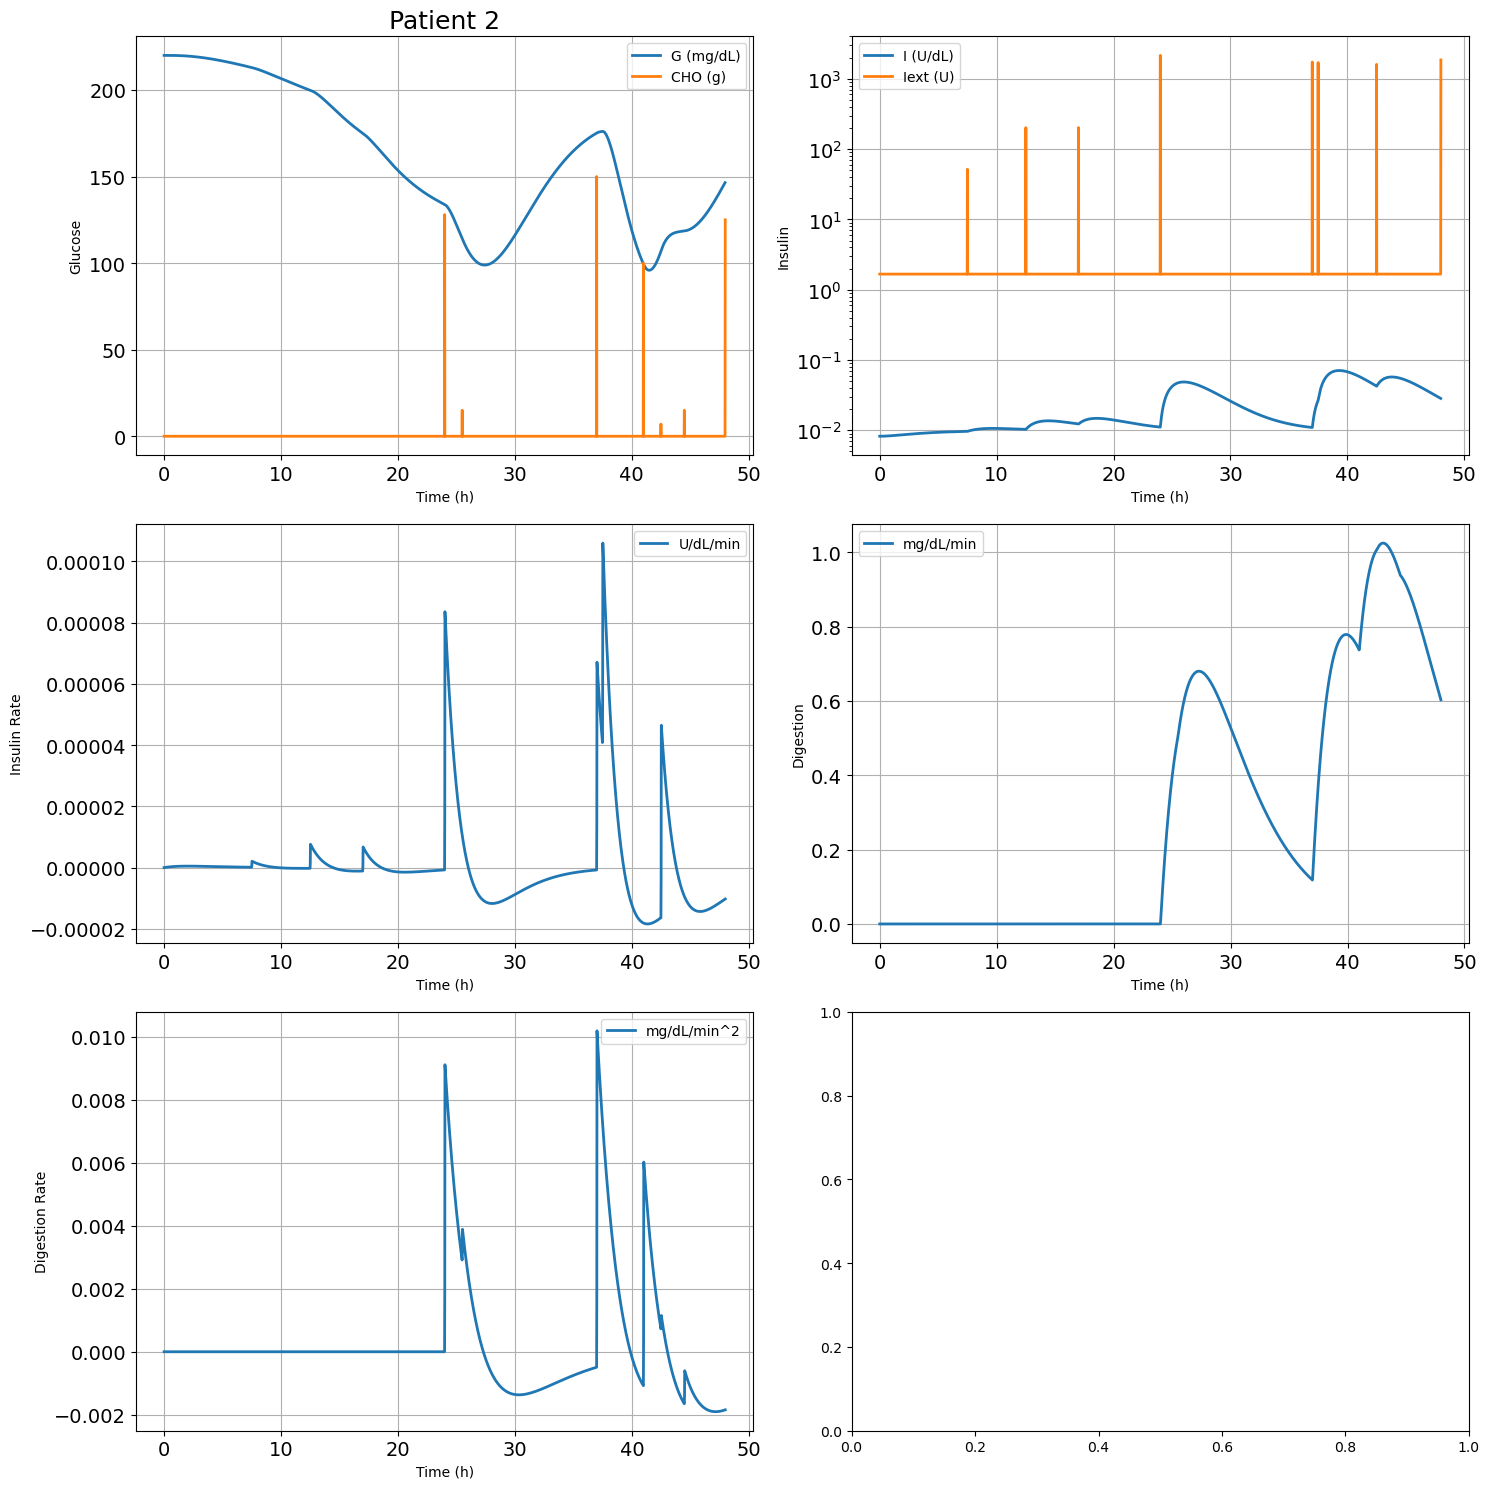

Done.


<Figure size 640x480 with 0 Axes>

In [3]:



Magdelaine1(2)


Running patient 3...


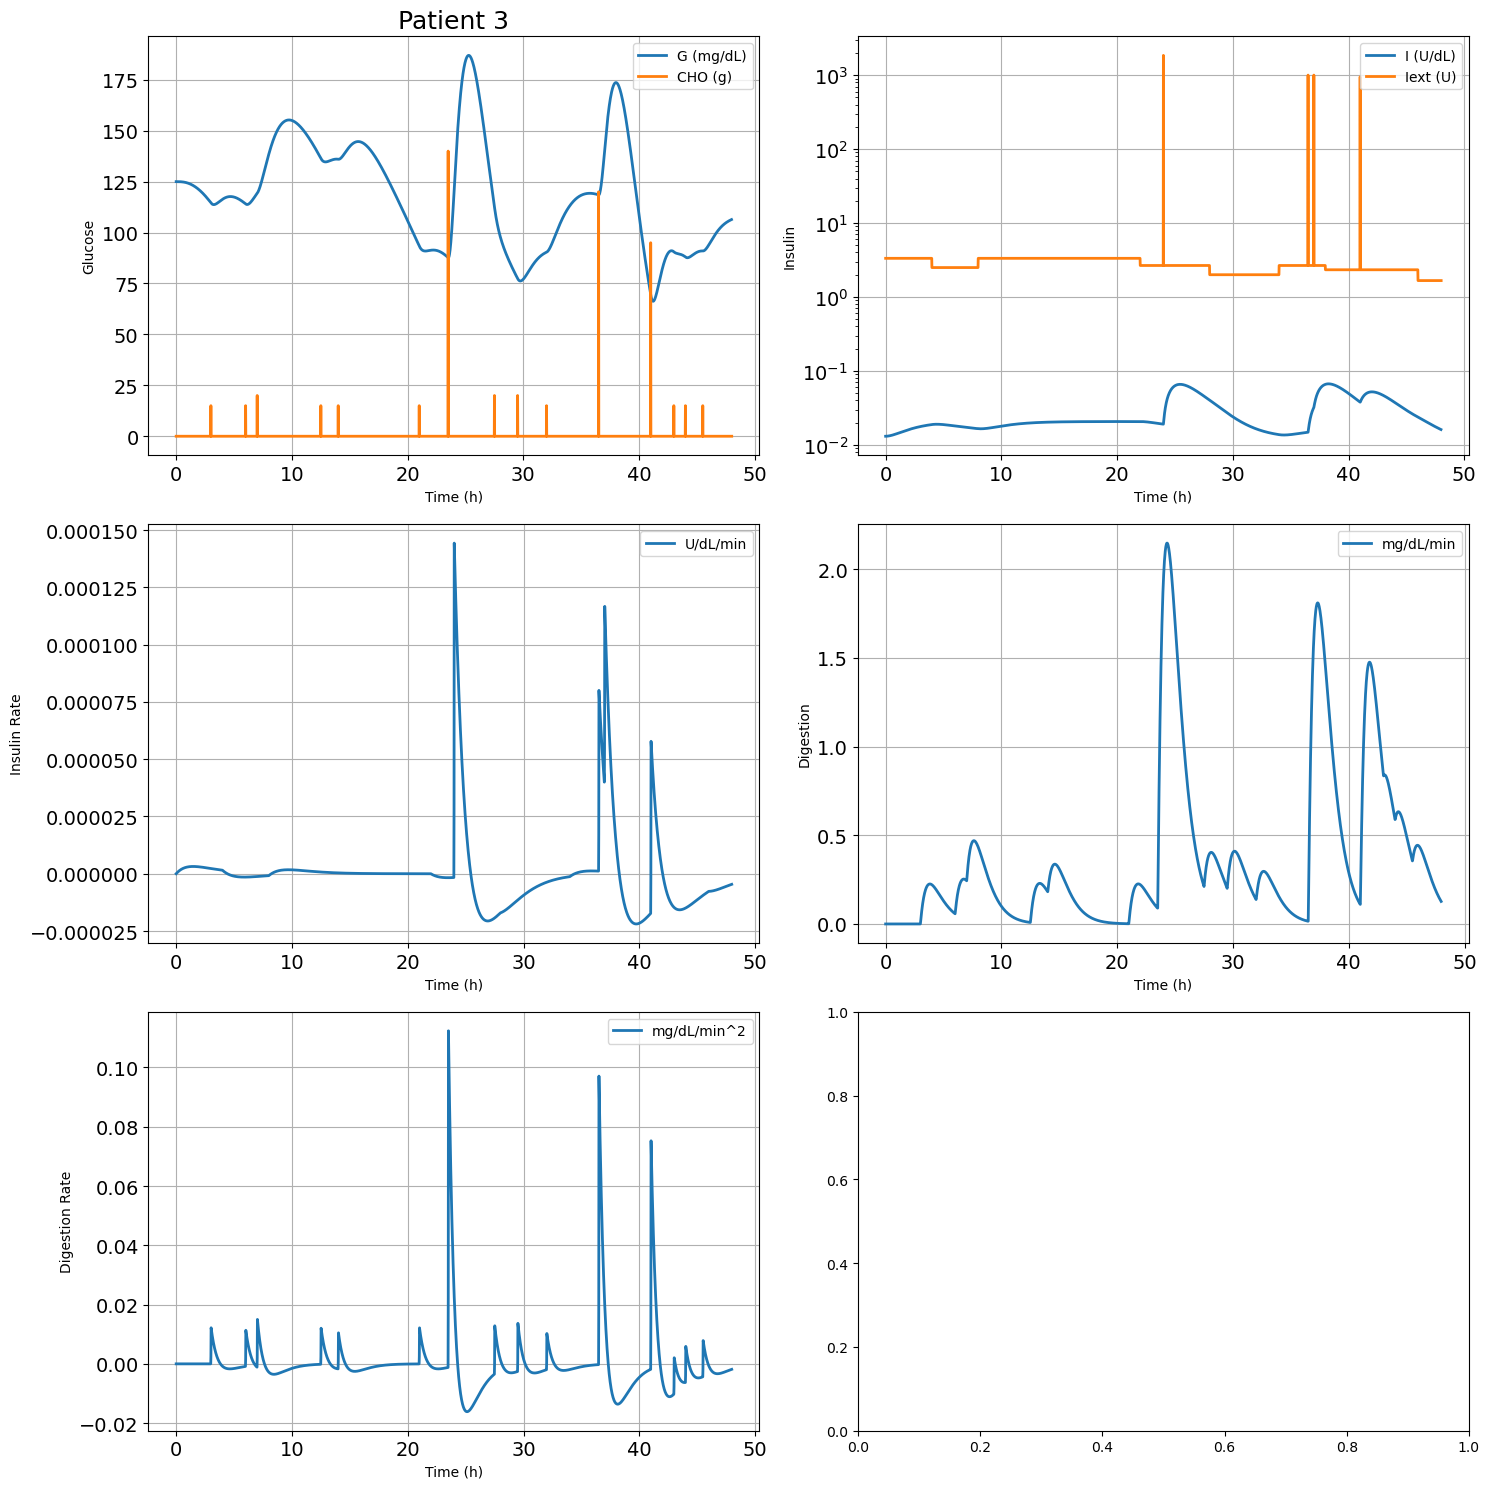

Done.


<Figure size 640x480 with 0 Axes>

In [4]:
Magdelaine1(3)